In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import datetime
import os
import random
import keras_tuner as kt
from sklearn.metrics import f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from tensorflow import math
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from tensorflow.keras.models import Model
from tensorflow.keras import layers, losses
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.layers import Dense, Dropout

In [3]:
# pd.set_option('display.max_rows', None)

In [3]:
insurance_df = pd.read_csv("Insurance_claims.csv")
insurance_df.head()

,ReferenceId,PolicyholderNumber,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,InsurerNotes,PolicyholderOccupation,LossDate,FirstPolicySubscriptionDate,ClaimCause,ClaimInvolvedCovers,...,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,LossHour,PolicyHolderAge,NumberOfBodilyInjuries,FirstPartyLiability,Fraud
0,4842,531112,715507.0,NaN,avoids a cat and hits a garage pole With deduc...,CivilServant,1/2/19,6/18/18,CollisionWithAnimal,MaterialDamages ActLiability,...,1,104.0,0.25,1,4624.73,8.0,45.0,0,1.0,0
1,4844,87170,71164.0,NaN,accident only expert contacts us to inform us ...,Worker,1/2/19,6/29/17,LossOfControl,MaterialDamages ActLiability,...,3,230.0,0.50,1,1606.81,11.0,20.0,0,1.0,0
2,4848,98706,442609.0,NaN,ae Miss/ for garage change A/ setting up EAD/ ...,Worker,1/2/19,2/5/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability,...,9,93.0,0.25,0,998.20,18.0,32.0,0,0.5,0
3,4849,38240,24604.0,NaN,"awaiting report to determine rc, no box checke...",CivilServant,1/2/19,1/21/17,AccidentWithIdentifiedThirdParty,MaterialDamages ActLiability ReplacementVehicle,...,2,56.0,0.25,0,2506.92,11.0,46.0,0,0.5,0
4,4850,11339,2933.0,229134.0,Insured in THIRD-PARTY formula Insured in a su...,Farmer,1/2/19,1/13/18,AccidentWithIdentifiedThirdParty,ActLiability,...,4,110.0,0.25,0,12.00,12.0,28.0,0,0.0,0


### For Q1, you need to describe the hit rate and detection rate metrics and their trade-off, and evaluate a model with given rates in monetary terms. Consider the following:

Hit Rate (Conversion Rate): Measures the model's effectiveness in identifying true fraud cases among the cases it flags. It's the ratio of true positives to the total flagged cases.

Detection Rate: Measures the model's ability to identify fraud cases from the entire dataset. It's the ratio of true positives to the total actual fraud cases.

Trade-off: Focusing solely on increasing the hit rate might decrease the detection rate as the model becomes too conservative, flagging only high-confidence cases. Conversely, aiming to increase the detection rate might decrease the hit rate as the model flags more cases, including more false positives.

Monetary Evaluation: Evaluate a model by considering the costs and savings involved. This includes the cost of false positives (incorrectly flagged cases), the cost of missed frauds (false negatives), the cost of investigating true positives, and the fixed capacity of investigation departments. Balancing these costs against the savings from identifying frauds gives a monetary value to the model's performance.

Remember to account for the fixed capacity of the investigation department, meaning that the investigation cost doesn't linearly increase with the number of flagged cases but is limited to the department's capacity. This affects the trade-off between the hit rate and detection rate and should be factored into the cost computation.

In [4]:
insurance_df.isna().sum().sort_values()

ReferenceId                            0
NumberOfBodilyInjuries                 0
ClaimAmount                            0
ClaimWihoutIdentifiedThirdParty        0
EasinessToStage                        0
NumberOfPoliciesOfPolicyholder         0
PolicyWasSubscribedOnInternet          0
PolicyHolderPostCode                   0
FirstPartyLiability                    0
Fraud                                  0
FirstPolicySubscriptionDate            0
LossDate                               0
PolicyholderNumber                     0
FirstPartyVehicleType                 12
FpVehicleAgeMonths                    12
PolicyHolderAge                       36
LossHour                              94
ClaimInvolvedCovers                  195
ClaimCause                           197
PolicyholderOccupation               343
FirstPartyVehicleNumber              495
LossPostCode                        1408
InsurerNotes                        2357
DamageImportance                   10792
ThirdPartyVehicl

In [5]:
insurance_df['FpVehicleAgeMonths'].mode()

0    144.0
Name: FpVehicleAgeMonths, dtype: float64

In [7]:
from sklearn.feature_extraction.text import TfidfVectorizer

insurance_df = pd.read_csv("Insurance_claims.csv")
# Sample data
text_data = insurance_df['InsurerNotes'].fillna("nonSpecified")  # replace 'text_column_name' with your actual column name

# Create the transform
vectorizer = TfidfVectorizer(max_features=500, min_df=5, max_df=0.75, stop_words='english')

# Tokenize and build vocab
X_tfidf = vectorizer.fit_transform(text_data)

# Convert the result to a dense DataFrame
df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names())


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [6]:
# insurance_df = pd.read_csv("Insurance_claims.csv")

insurance_df = insurance_df.drop(
    columns=["ReferenceId", "PolicyholderNumber","InsurerNotes"]
)

insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])

insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])
insurance_df["FirstPolicySubscriptionDate"] = pd.to_datetime(insurance_df["FirstPolicySubscriptionDate"])

# calculate the number of days between the two dates
insurance_df["days_between"] = insurance_df.apply(
    lambda row: (row["LossDate"] - row["FirstPolicySubscriptionDate"]).days, axis=1
)

insurance_df = insurance_df.drop(columns=["LossDate", "FirstPolicySubscriptionDate"])

# Convert the columns to integer type
insurance_df['LossPostCode'] = pd.to_numeric(insurance_df['LossPostCode'], errors='coerce')
insurance_df['PolicyHolderPostCode'] = pd.to_numeric(insurance_df['PolicyHolderPostCode'], errors='coerce')

insurance_df['FirstPartyVehicleNumber_DupCount'] = insurance_df['FirstPartyVehicleNumber'].transform(lambda x: x.map(x.value_counts()))
insurance_df['FirstPartyVehicleNumber_DupCount'] = insurance_df['FirstPartyVehicleNumber_DupCount'].fillna(0)
insurance_df["FirstPartyVehicleNumber"] = insurance_df["FirstPartyVehicleNumber"].fillna(0)

insurance_df['ThirdPartyVehicleNumber_DupCount'] = insurance_df['ThirdPartyVehicleNumber'].transform(lambda x: x.map(x.value_counts()))
insurance_df["ThirdPartyVehicleNumber_DupCount"] = insurance_df["ThirdPartyVehicleNumber_DupCount"].fillna(0)
insurance_df["ThirdPartyVehicleNumber"] = insurance_df["ThirdPartyVehicleNumber"].fillna(0)


insurance_df['PolicyholderOccupation'] = insurance_df['PolicyholderOccupation'].fillna('nonSpecified')
insurance_df['ClaimCause'] = insurance_df['ClaimCause'].fillna('nonSpecified')
insurance_df['ClaimInvolvedCovers'] = insurance_df['ClaimInvolvedCovers'].fillna('nonSpecified')
insurance_df["DamageImportance"] = insurance_df["DamageImportance"].fillna('nonSpecified')
insurance_df['FirstPartyVehicleType'] = insurance_df['FirstPartyVehicleType'].fillna('nonSpecified')
insurance_df['ConnectionBetweenParties'] = insurance_df['ConnectionBetweenParties'].fillna('nonSpecified')
insurance_df["LossPostCode"] = insurance_df["LossPostCode"].fillna(0)
insurance_df['EasinessToStage'] = insurance_df['EasinessToStage'].fillna(insurance_df['EasinessToStage'].mean())
insurance_df['FpVehicleAgeMonths'] = insurance_df['FpVehicleAgeMonths'].fillna(insurance_df['FpVehicleAgeMonths'].mode()[0])
insurance_df['LossHour'] = insurance_df['LossHour'].fillna(insurance_df['LossHour'].mean())
insurance_df['PolicyHolderAge'] = insurance_df['PolicyHolderAge'].fillna(insurance_df['PolicyHolderAge'].mean())
insurance_df['PolicyHolderPostCode'] = insurance_df['PolicyHolderPostCode'].fillna(insurance_df['PolicyHolderPostCode'].mode()[0])


# check the two postcodes
def compare_digits(x, y):
    x_len = len(str(x))
    y_len = len(str(y))
    if x_len == y_len:
        if x_len == 5:
            return str(x)[:2] == str(y)[:2]
        elif x_len == 4:
            return str(x)[0] == str(y)[0]
        else:
            return False
    else:
        return False


# check if the loss place is in the same district of the holder's place
insurance_df["IfinSameArea"] = insurance_df.apply(
    lambda row: 1
    if compare_digits(row["LossPostCode"], row["PolicyHolderPostCode"])
    else 0,
    axis=1,
)

/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_20304/3282033013.py:7: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  insurance_df["LossDate"] = pd.to_datetime(insurance_df["LossDate"])
/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_20304/3282033013.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  insurance_df["FirstPolicySubscriptionDate"] = pd.to_datetime(insurance_df["FirstPolicySubscriptionDate"])


In [7]:
insurance_df.isna().sum()

FirstPartyVehicleNumber             0
ThirdPartyVehicleNumber             0
PolicyholderOccupation              0
ClaimCause                          0
ClaimInvolvedCovers                 0
DamageImportance                    0
FirstPartyVehicleType               0
ConnectionBetweenParties            0
LossPostCode                        0
PolicyHolderPostCode                0
PolicyWasSubscribedOnInternet       0
NumberOfPoliciesOfPolicyholder      0
FpVehicleAgeMonths                  0
EasinessToStage                     0
ClaimWihoutIdentifiedThirdParty     0
ClaimAmount                         0
LossHour                            0
PolicyHolderAge                     0
NumberOfBodilyInjuries              0
FirstPartyLiability                 0
Fraud                               0
days_between                        0
FirstPartyVehicleNumber_DupCount    0
ThirdPartyVehicleNumber_DupCount    0
IfinSameArea                        0
dtype: int64

In [8]:
object_columns = insurance_df.select_dtypes(include=['object']).columns.tolist()
object_columns

['PolicyholderOccupation',
 'ClaimCause',
 'ClaimInvolvedCovers',
 'DamageImportance',
 'FirstPartyVehicleType',
 'ConnectionBetweenParties']

In [9]:
# Perform one-hot encoding
# set these columns to dummies
insurance_df = pd.get_dummies(
    insurance_df,
    columns=object_columns,
    dtype='int32'
)

In [10]:
insurance_df.head()

,FirstPartyVehicleNumber,ThirdPartyVehicleNumber,LossPostCode,PolicyHolderPostCode,PolicyWasSubscribedOnInternet,NumberOfPoliciesOfPolicyholder,FpVehicleAgeMonths,EasinessToStage,ClaimWihoutIdentifiedThirdParty,ClaimAmount,...,FirstPartyVehicleType_Caravan,FirstPartyVehicleType_Motorcycle,FirstPartyVehicleType_PrivateCar,FirstPartyVehicleType_nonSpecified,ConnectionBetweenParties_SameAddress,ConnectionBetweenParties_SameBankAccount,ConnectionBetweenParties_SameEmail,ConnectionBetweenParties_SamePhone,ConnectionBetweenParties_SamePolice,ConnectionBetweenParties_nonSpecified
0,715507.0,0.0,31330.0,31330.0,1,1,104.0,0.25,1,4624.73,...,0,0,0,0,0,0,0,0,0,1
1,71164.0,0.0,29810.0,29200.0,0,3,230.0,0.50,1,1606.81,...,0,0,0,0,0,0,0,0,0,1
2,442609.0,0.0,33500.0,33500.0,0,9,93.0,0.25,0,998.20,...,0,0,0,0,0,0,0,0,0,1
3,24604.0,0.0,35310.0,35310.0,0,2,56.0,0.25,0,2506.92,...,0,0,0,0,0,0,0,0,0,1
4,2933.0,229134.0,29600.0,22000.0,0,4,110.0,0.25,0,12.00,...,0,0,0,0,0,0,0,0,0,1


In [11]:
insurance_df.Fraud.value_counts()

Fraud
0    11415
1      115
Name: count, dtype: int64

In [12]:
insurance_df.to_csv('test1.csv')

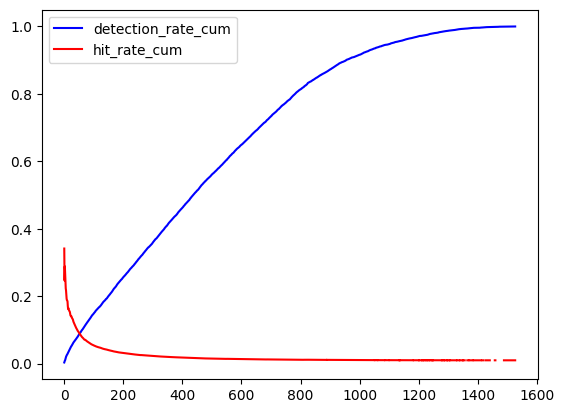

In [17]:
import numpy as np
import matplotlib.pyplot as plt

detection = insurance_df.groupby(['days_between']).size().reset_index(name='count')
detection.loc[:, "count_cum"] = detection['count'].cumsum()
detection.loc[:, "detection_rate_cum"] =  detection[['count_cum']]/len(insurance_df)
detection.loc[:, "fraud_cum"]  = insurance_df.groupby(['days_between'])[['Fraud']].sum().cumsum()
detection.loc[:, "hit_rate_cum"] = detection['fraud_cum']/detection['count_cum']


x = detection['days_between']
f = detection['detection_rate_cum']
g = detection['hit_rate_cum']

plt.plot(x, f, "-b", label="detection_rate_cum")
plt.plot(x, g, "-r", label="hit_rate_cum")
plt.legend(loc="upper left")

plt.show()

In [13]:
y = insurance_df["Fraud"]  # creating the dependent variable
X = insurance_df.drop(columns=["Fraud"])


X_train, X_test, Y_train, Y_test = train_test_split(
    X, y, train_size=0.7, random_state=111
)

# X_test, X_valid, Y_test, Y_valid = train_test_split(
#     X_other, Y_other, test_size=0.5, random_state=111
# )

print(Y_test.value_counts())

smote = SMOTE(random_state=111, sampling_strategy=0.2)
X_train_smote, Y_train_smote = smote.fit_resample(X_train, Y_train)


# Checking the shapes of the datasets
print("Shapes of datasets:")
print("X_train (before SMOTE):", X_train.shape)
print("Y_train (before SMOTE):", Y_train.shape)
print("X_train (after SMOTE):", X_train_smote.shape)
print("Y_train (after SMOTE):", Y_train_smote.shape)
print("X_test:", X_test.shape)
print("Y_test:", Y_test.shape)


Fraud
0    3430
1      30
Name: count, dtype: int64
Shapes of datasets:
X_train (before SMOTE): (8070, 132)
Y_train (before SMOTE): (8070,)
X_train (after SMOTE): (9582, 132)
Y_train (after SMOTE): (9582,)
X_test: (3460, 132)
Y_test: (3460,)


In [14]:
Y_train_smote.value_counts(),Y_train.value_counts(),Y_test.value_counts()

(Fraud
 0    7985
 1    1597
 Name: count, dtype: int64,
 Fraud
 0    7985
 1      85
 Name: count, dtype: int64,
 Fraud
 0    3430
 1      30
 Name: count, dtype: int64)

In [15]:
scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)
# X_valid_scaled = scaler.transform(X_valid)
# X_valid_scaled.shape

In [17]:
dt_model = DecisionTreeClassifier(random_state=111)
dt_model.fit(X_train_smote, Y_train_smote)

dt_y_pred = dt_model.predict(X_test)

print("Decision Tree classifier: \n", classification_report(Y_test, dt_y_pred))

Decision Tree classifier: 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      3430
           1       0.14      0.23      0.18        30

    accuracy                           0.98      3460
   macro avg       0.57      0.61      0.58      3460
weighted avg       0.99      0.98      0.98      3460



In [18]:
def hit_detection_rates(Pred, model):
    Pred = model.predict(X_test)
    hits1 = sum(Y_test & Pred)

    hit_rate1 = hits1 / Pred.sum()
    detection_rate1 = hits1 / Y_test.sum()

    print("Hit rate:", hit_rate1)
    print("Detection rate:", detection_rate1)

In [19]:
# Create a list of tuples with feature names and their importance scores
feature_importances = [(feature, importance) for feature, importance in zip(dt_model.feature_names_in_, dt_model.feature_importances_)]

# Sort the list of feature importances in descending order
feature_importances = sorted(feature_importances, key=lambda x: x[1], reverse=True)

# Print the first 10 most important features
for feature, importance in feature_importances[:10]:
    print(f"{feature}: {importance:.4f}")

days_between: 0.4045
ConnectionBetweenParties_nonSpecified: 0.1614
DamageImportance_TotalLoss: 0.0681
DamageImportance_nonSpecified: 0.0515
ClaimCause_WindscreenDamage: 0.0514
ClaimAmount: 0.0443
DamageImportance_Medium: 0.0257
FirstPartyVehicleNumber: 0.0195
ConnectionBetweenParties_SameAddress: 0.0184
FirstPartyLiability: 0.0164


In [31]:
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_smote),
    y=Y_train_smote
)

class_weights_dict = dict(enumerate(class_weights))


model = Sequential()
model.add(Dense(32, input_shape=(X_train_scaled.shape[1],)))
model.add(tf.keras.layers.ReLU())

model.add(Dense(16))
model.add(tf.keras.layers.ReLU())

model.add(Dense(16))
model.add(tf.keras.layers.ReLU())

model.add(Dense(8))
model.add(tf.keras.layers.ReLU())

model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer=tf.keras.optimizers.RMSprop(), 
              loss='binary_crossentropy', 
              metrics=[tf.keras.metrics.TruePositives(name='tp'),
                        tf.keras.metrics.TrueNegatives(name='tn'),
                        tf.keras.metrics.PrecisionAtRecall(recall=0.4, name='par')])

# Then pass this dictionary to the class_weight parameter in the fit method
history = model.fit(X_train_scaled, Y_train_smote, epochs=20, batch_size=64, 
                    validation_split=0.2, class_weight=class_weights_dict)

# Predict probabilities
probabilities = model.predict(X_test_scaled).ravel()

# Compute precision-recall curve
precision, recall, thresholds = precision_recall_curve(Y_test, probabilities)

# Calculate the F1 score for each threshold
f1_scores = 2 * recall * precision / (recall + precision)
# Find the index of the highest F1 score
best_threshold_index = np.argmax(f1_scores)

# Find the best threshold that gives the highest F1 score
best_threshold = thresholds[best_threshold_index]

# Make predictions based on the best threshold
y_pred_threshold = (probabilities >= best_threshold).astype(int)

# Print classification report based on the best threshold
print(f'Best threshold: {best_threshold}')
print(classification_report(Y_test, y_pred_threshold))


Epoch 1/20


2024-02-04 23:57:09.638272: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

117/120 [============================>.] - ETA: 0s - loss: 0.1522 - tp: 0.0000e+00 - tn: 7407.0000 - par: 0.0147

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x49x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x49x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

120/120 [==============================] - ETA: 0s - loss: 0.1514 - tp: 0.0000e+00 - tn: 7582.0000 - par: 0.0150

2024-02-04 23:57:14.094491: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

120/120 [==============================] - 6s 37ms/step - loss: 0.1514 - tp: 0.0000e+00 - tn: 7582.0000 - par: 0.0150 - val_loss: 1.6712 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_par: 0.9969
Epoch 2/20
  4/120 [>.............................] - ETA: 2s - loss: 0.1096 - tp: 0.0000e+00 - tn: 253.0000 - par: 0.2222

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x61x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x61x1x1xi1>'


120/120 [==============================] - 3s 21ms/step - loss: 0.1032 - tp: 0.0000e+00 - tn: 7582.0000 - par: 0.0541 - val_loss: 1.1455 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_par: 0.9988
Epoch 3/20
120/120 [==============================] - 3s 21ms/step - loss: 0.0866 - tp: 0.0000e+00 - tn: 7582.0000 - par: 0.1377 - val_loss: 1.0477 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_par: 1.0000
Epoch 4/20
120/120 [==============================] - 3s 22ms/step - loss: 0.0769 - tp: 2.0000 - tn: 7582.0000 - par: 0.2448 - val_loss: 0.9197 - val_tp: 202.0000 - val_tn: 403.0000 - val_par: 1.0000
Epoch 5/20
120/120 [==============================] - 2s 21ms/step - loss: 0.0722 - tp: 13.0000 - tn: 7571.0000 - par: 0.2537 - val_loss: 0.7438 - val_tp: 763.0000 - val_tn: 402.0000 - val_par: 1.0000
Epoch 6/20
120/120 [==============================] - 3s 21ms/step - loss: 0.0679 - tp: 20.0000 - tn: 7559.0000 - par: 0.2434 - val_loss: 0.7074 - val_tp: 957.0000 - val_tn: 401.0000 - val_par: 0.99

2024-02-04 23:58:03.619336: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


109/109 [==============================] - 0s 3ms/step
Best threshold: 0.9406777620315552
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3430
           1       0.00      0.00      0.00        30

    accuracy                           0.99      3460
   macro avg       0.50      0.50      0.50      3460
weighted avg       0.98      0.99      0.99      3460



/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_19849/2210737306.py:47: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TruePositives, TrueNegatives, Precision, Recall
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_smote),
    y=Y_train_smote
)

class_weights_dict = dict(enumerate(class_weights))

# Model configuration
input_shape = (X_train_scaled.shape[1],)
batch_size = 64
no_epochs = 20
learning_rate = 0.001
l1_reg = 0.01
l2_reg = 0.01
dropout_rate = 0.5

# Define the neural network model
model = Sequential()

# Input Layer
model.add(Dense(64, input_shape=input_shape, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Hidden Layers
model.add(Dense(128, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Hidden Layers
model.add(Dense(256, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Dense(64, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Output Layer
model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy', 
              metrics=[TruePositives(name='tp'),
                       TrueNegatives(name='tn'),
                       Precision(name='precision'),
                       Recall(name='recall')])

# Fit the model
history = model.fit(X_train_scaled, Y_train_smote, 
                    batch_size=batch_size, 
                    epochs=no_epochs, 
                    verbose=1,
                    validation_split=0.2, 
                    class_weight=class_weights_dict)

# Evaluate the model
evaluation = model.evaluate(X_test_scaled, Y_test, verbose=1)
print('\nTest set loss:', evaluation[0])
print('Test set accuracy:', evaluation[1])

# Predict probabilities
probabilities = model.predict(X_test_scaled).ravel()

# Find the optimal threshold
precision, recall, thresholds = precision_recall_curve(Y_test, probabilities)
f1_scores = 2 * recall * precision / (recall + precision)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# Make predictions based on the best threshold
y_pred_threshold = (probabilities >= best_threshold).astype(int)

# Print classification report based on the best threshold
print(f'\nBest threshold: {best_threshold}')
print(classification_report(Y_test, y_pred_threshold))


2024-02-05 00:22:29.039813: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-05 00:22:29.039998: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Epoch 1/20


2024-02-05 00:22:29.597887: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-02-05 00:22:30.304545: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be

118/120 [============================>.] - ETA: 0s - loss: 25.0113 - tp: 24.0000 - tn: 5526.0000 - precision: 0.0122 - recall: 0.2963

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x49x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x49x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

120/120 [==============================] - ETA: 0s - loss: 24.7606 - tp: 24.0000 - tn: 5632.0000 - precision: 0.0122 - recall: 0.2892

2024-02-05 00:22:41.030440: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'


120/120 [==============================] - 13s 62ms/step - loss: 24.7606 - tp: 24.0000 - tn: 5632.0000 - precision: 0.0122 - recall: 0.2892 - val_loss: 8.5460 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
  1/120 [..............................] - ETA: 5s - loss: 7.8442 - tp: 0.0000e+00 - tn: 58.0000 - precision: 0.0000e+00 - recall: 0.0000e+00

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x61x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x61x1x1xi1>'


120/120 [==============================] - 6s 49ms/step - loss: 3.8108 - tp: 8.0000 - tn: 7075.0000 - precision: 0.0155 - recall: 0.0964 - val_loss: 3.4120 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
120/120 [==============================] - 6s 49ms/step - loss: 1.3528 - tp: 3.0000 - tn: 7404.0000 - precision: 0.0166 - recall: 0.0361 - val_loss: 2.5197 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
120/120 [==============================] - 6s 48ms/step - loss: 0.7777 - tp: 1.0000 - tn: 7451.0000 - precision: 0.0076 - recall: 0.0120 - val_loss: 2.2271 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
120/120 [==============================] - 6s 47ms/step - loss: 0.5061 - tp: 3.0000 - tn: 7503.0000 - precision: 0.0366 - recall: 0.0361 - val_loss: 2.3202 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


109/109 [==============================] - 4s 31ms/step - loss: 0.1615 - tp: 0.0000e+00 - tn: 3430.0000 - precision: 0.0000e+00 - recall: 0.0000e+00


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x1xi1>'
2024-02-05 00:24:34.847803: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Test set loss: 0.161484956741333
Test set accuracy: 0.0
109/109 [==============================] - 1s 5ms/step

Best threshold: 0.0773087590932846
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3430
           1       0.00      0.00      0.00        30

    accuracy                           0.99      3460
   macro avg       0.50      0.50      0.50      3460
weighted avg       0.98      0.99      0.99      3460



/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_20304/1133287378.py:82: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)


In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import TruePositives, TrueNegatives, Precision, Recall
from sklearn.metrics import precision_recall_curve, classification_report
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(Y_train_smote),
    y=Y_train_smote
)

class_weights_dict = dict(enumerate(class_weights))

# Model configuration
input_shape = (X_train_scaled.shape[1],)
batch_size = 64
no_epochs = 20
learning_rate = 0.001
l1_reg = 0.01
l2_reg = 0.01
dropout_rate = 0.5

# Define the neural network model
model = Sequential()

# Input Layer
model.add(Dense(64, input_shape=input_shape, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Hidden Layers
model.add(Dense(128, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

model.add(Dense(64, kernel_regularizer=l1_l2(l1=l1_reg, l2=l2_reg)))
model.add(LeakyReLU())
model.add(BatchNormalization())
model.add(Dropout(dropout_rate))

# Output Layer
model.add(Dense(1, activation='sigmoid')) 

# Compile the model
model.compile(optimizer=Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy', 
              metrics=[TruePositives(name='tp'),
                       TrueNegatives(name='tn'),
                       Precision(name='precision'),
                       Recall(name='recall')])

# Fit the model
history = model.fit(X_train_scaled, Y_train_smote, 
                    batch_size=batch_size, 
                    epochs=no_epochs, 
                    verbose=1,
                    validation_split=0.2, 
                    class_weight=class_weights_dict)

# Evaluate the model
evaluation = model.evaluate(X_test_scaled, Y_test, verbose=1)
print('\nTest set loss:', evaluation[0])
print('Test set accuracy:', evaluation[1])

# Predict probabilities
probabilities = model.predict(X_test_scaled).ravel()

# Find the optimal threshold
precision, recall, thresholds = precision_recall_curve(Y_test, probabilities)
f1_scores = 2 * recall * precision / (recall + precision)
best_threshold_index = np.argmax(f1_scores)
best_threshold = thresholds[best_threshold_index]

# Make predictions based on the best threshold
y_pred_threshold = (probabilities >= best_threshold).astype(int)

# Print classification report based on the best threshold
print(f'\nBest threshold: {best_threshold}')
print(classification_report(Y_test, y_pred_threshold))

Epoch 1/20


2024-02-05 00:25:03.456519: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc

118/120 [============================>.] - ETA: 0s - loss: 14.4263 - tp: 25.0000 - tn: 5412.0000 - precision: 0.0120 - recall: 0.3125

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x49x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x49x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceSh

120/120 [==============================] - ETA: 0s - loss: 14.3096 - tp: 25.0000 - tn: 5508.0000 - precision: 0.0119 - recall: 0.3012

2024-02-05 00:25:09.297447: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x64x1x1xi1>'


120/120 [==============================] - 8s 50ms/step - loss: 14.3096 - tp: 25.0000 - tn: 5508.0000 - precision: 0.0119 - recall: 0.3012 - val_loss: 7.0208 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/20
  3/120 [..............................] - ETA: 4s - loss: 6.1460 - tp: 1.0000 - tn: 169.0000 - precision: 0.0455 - recall: 0.5000           

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x61x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x61x1x1xi1>'


120/120 [==============================] - 5s 41ms/step - loss: 3.1802 - tp: 9.0000 - tn: 7111.0000 - precision: 0.0188 - recall: 0.1084 - val_loss: 2.7329 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/20
120/120 [==============================] - 5s 41ms/step - loss: 1.0258 - tp: 4.0000 - tn: 7378.0000 - precision: 0.0192 - recall: 0.0482 - val_loss: 2.1291 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 4/20
120/120 [==============================] - 5s 40ms/step - loss: 0.6176 - tp: 4.0000 - tn: 7414.0000 - precision: 0.0233 - recall: 0.0482 - val_loss: 2.1714 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/20
120/120 [==============================] - 5s 40ms/step - loss: 0.3852 - tp: 1.0000 - tn: 7494.0000 - precision: 0.0112 - recall: 0.0120 - val_loss: 2.0649 - val_tp: 0.0000e+00 - val_tn: 403.0000 - val_precision: 0.0000e

loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x32x1x1xi1>'


109/109 [==============================] - 3s 26ms/step - loss: 0.1198 - tp: 0.0000e+00 - tn: 3430.0000 - precision: 0.0000e+00 - recall: 0.0000e+00


loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x1xi1>'
loc("mps_select"("(mpsFileLoc): /AppleInternal/Library/BuildRoots/0032d1ee-80fd-11ee-8227-6aecfccc70fe/Library/Caches/com.apple.xbs/Sources/MetalPerformanceShadersGraph/mpsgraph/MetalPerformanceShadersGraph/Core/Files/MPSGraphUtilities.mm":294:0)): error: 'anec.gain_offset_control' op result #0 must be 4D/5D memref of 16-bit float or 8-bit signed integer or 8-bit unsigned integer values, but got 'memref<1x4x1x1xi1>'
2024-02-05 00:26:44.683412: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.



Test set loss: 0.11980283260345459
Test set accuracy: 0.0
109/109 [==============================] - 1s 4ms/step

Best threshold: 0.1868910938501358
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      3430
           1       0.00      0.00      0.00        30

    accuracy                           0.99      3460
   macro avg       0.50      0.50      0.50      3460
weighted avg       0.98      0.99      0.99      3460



/var/folders/k6/934yyy2n5_vf8y3c9cw39gcr0000gn/T/ipykernel_20304/1278090715.py:76: RuntimeWarning: invalid value encountered in divide
  f1_scores = 2 * recall * precision / (recall + precision)
